In [1]:
%run init_notebook.py

In [2]:
import spacy
import regex as re

import time
from itertools import compress
from collections import Counter
from src.utils import vec_similarity, arr_min_max_scale, save_pd_df

from matplotlib.pyplot import cm

from uuid import uuid4
import pickle

In [3]:
from articles import load_pickle, DICT_NARRATIVES, load_pd_df
from src.nlp_utils import get_spacy_NLP, load_raw_data

In [4]:
NLP = get_spacy_NLP('de')

# supervised narrative topics

news data

In [5]:
dict_txts = {}
for file in [i for i in os.listdir(NEWS_TEXT_DIR) if i not in ['orig']]:
    dict_txts[file.split('.')[0]] = load_pickle(file)

len(dict_txts)

25674

In [6]:
Counter([v['is_infl'] for k, v in dict_txts.items()])

Counter({True: 25674})

ecb speeches

In [7]:
# dict_txts = {}
# for file in [i for i in os.listdir(TEXT_DIR) if i != 'orig']:
#     dict_txts[file] = load_pickle(file)

## analyse

In [11]:
LST_FREQUENT_NON_MEANING = [
    'prozent',
     'euro',
     'million',
     'milliarde',
     'deutschland',
     'deutsch',
     'land',
     'firma',
     'frage',
    'zahl',
    'woche',
    'monat',
    'stadt',
    'bereich',
    'seite',
    'datum',
    'quartal',
    'tonne',
    'zeit',
    'entwicklung',
    'standort',
    "vergleich", "jahr", "experte", "anfangm", "lage", "thema", "anteil", "blick", "weg", "meinungen", "punkt", "januar", "september", "maßnahme", "juni", "situation", "hälfte", 
"angabe", "jahrzehnt", "juli", "institut", "region", "vorjahr", "frau", "april",
    "kilometer", "dienstag", "system", "familie", "mitt", "gespräch", "mai", "niveau", "oktober", "lösung", "modell", "idee", "dezember", "prognose", "papier", "drittel", "schnitt", 
"mal", "strategie", "november", "platz", "mittwoch", "montag", "stelle", "august", "februar", "teil", "stunde", "hand", "name", "freitag", "halbjahr", "umfrage", "prozentpunkt", 
"stand", "wort", "summe",
]

In [12]:
'nordstream'.lower() in " ".join([v['text'] for v in dict_txts.values()])

False

In [13]:
_dict = {}
for idx, text in {k: v for k, v in dict_txts.items() if v['is_infl']}.items():
    counter = text['counter_nouns']
    for k, v in counter.items():
        if k not in LST_FREQUENT_NON_MEANING:
            if k not in _dict.keys():
                _dict[k] = v
            elif k in _dict.keys():
                _dict[k] = _dict[k] + v
c = sorted(_dict.items(), key=lambda x: x[1], reverse=True)

In [14]:
NLP('gas')[0].similarity(NLP('erdgas')[0])

0.5730186104774475

In [15]:
# [i for i in c if 'pipeline' in i[0]]
# c[100:200]

In [ ]:
# from scratch

In [ ]:
# lst_docs = [NLP(i['text']) for i in list(dict_txts.values())]

# doc = lst_docs[0]

# for noun_phrase in list(doc.noun_chunks):
#     noun_phrase.merge(noun_phrase.root.tag_, noun_phrase.root.lemma_, noun_phrase.root.ent_type_)

In [ ]:
# [" ".join([lst_docs[0][i-1].lemma_.lower(), lst_docs[0][i].lemma_.lower()]) for i in range(1, len(lst_docs[0])-1)]

In [ ]:
# x = [*lst_docs[0].noun_chunks][1

In [ ]:
# lst_nouns = [
#     [
#         i for i in doc if 
#         (
#             i.is_alpha
#             and 
#             (
#                 i.pos_ in ['NOUN', 'PROPN', 'ADJ']
#                 # and i.ent_type_ == ""
#             )
#             and not (i.is_stop or i.is_punct or i.is_currency or i.is_bracket)
#             and i.lemma_.lower() not in LST_FREQUENT_NON_MEANING
#         )
#     ] for doc in lst_docs
# ]

# c = sorted(Counter([i.lemma_.lower() for i in [*chain(*lst_nouns)]]).items(), key=lambda x: x[1], reverse=True)

In [ ]:
# sorted(_dict.items(), key=lambda x: x[1], reverse=True)

# narrative scores

In [69]:
df = pd.DataFrame(
    {
        (dkey, doc['date']) : {
            nkey: narrative['narrative_score_det'] for nkey, narrative in doc['narratives'].items()
        } for dkey, doc in dict_txts.items()
    }
).T.sort_index()
df = df.reset_index(names=['id', 'date'])

In [70]:
df_g = df.drop('id', axis=1).groupby('date').sum().copy()
df_g.iloc[:, : ] = df_g.values / df.groupby('date').id.count().values[:,None]
df_g = df_g.rolling(30).mean()


In [67]:
df_g2 = df.drop('id', axis=1).groupby('date').sum().copy() #/ df.groupby('date').id.count()
df_g2.iloc[:, : ] = df_g2.values / df.groupby('date').id.count().values[:,None]
df_g2 = df_g2.rolling(30).mean()


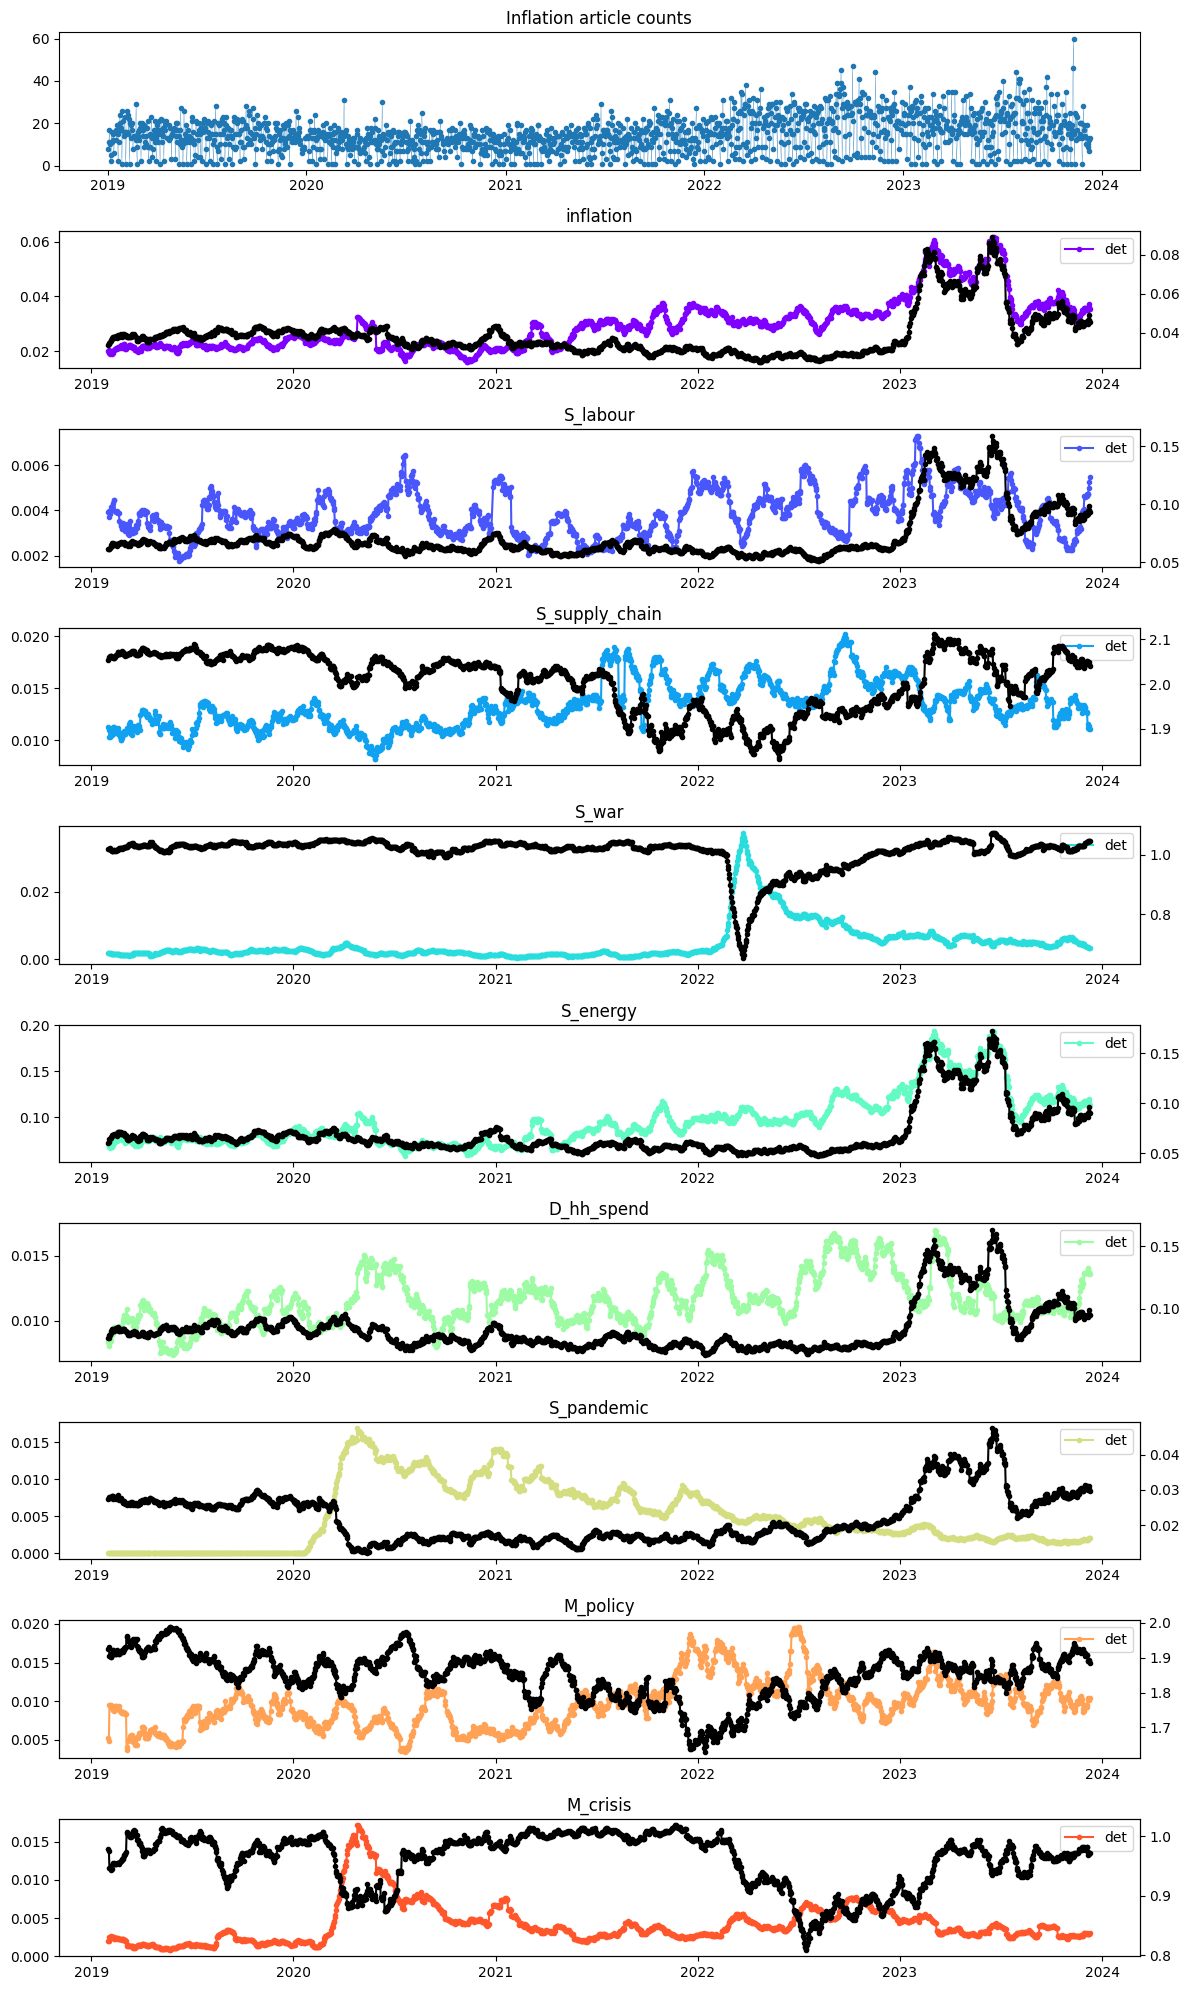

In [71]:
nrows = df_g.shape[1] + 1
fig, axes = plt.subplots(nrows, 1, figsize=(12, 2 * nrows))
color = cm.rainbow(np.linspace(0, 1, nrows))

axes.ravel()[0].plot(df.groupby('date').id.count(), lw=0.2, marker='.')
axes.ravel()[0].set_title('Inflation article counts')
for i, ax in enumerate(axes.ravel()[1:]):
    ax.plot(df_g.iloc[:, i], c=color[i], marker='.', )
    ax.twinx().plot(df_g2.iloc[:, i], c='black', marker='.',)
    ax.set_title(label=df_g.columns[i])
    ax.legend(['det', 'sim'])
            
    
plt.tight_layout()

In [37]:
sorted(
    Counter([*chain(*[dict_txts[i]['narratives']['S_supply_chain']['narrative_chunk_det'] for i in dict_txts.keys()])]).items(),
    key=lambda x: x[1],
    reverse=True
    );

<AxesSubplot: >

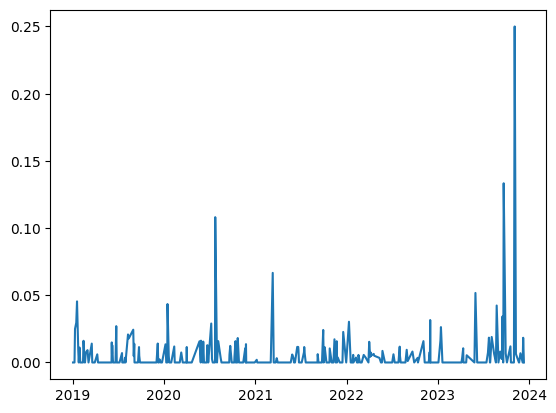

In [39]:
df['S_supply_chain'].plot()

# supervised BERT topic

In [34]:
from bertopic import BERTopic
from sklearn.datasets import fetch_20newsgroups

In [21]:
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.linear_model import LogisticRegression

In [35]:
docs = fetch_20newsgroups(subset='all',  remove=('headers', 'footers', 'quotes'))["data"]

In [45]:
lst_topic_seeds = [
  ['term', 'condition',  'area',  'conference',  'corporation'],
  ['risk',  'outlook',  'assessment',  'credit',  'loan'],
  ['interest',  'prices',  'household',  'inflation',  'expectation']
]

In [46]:
txts = [" ".join([i.lemma_.lower() for i in doc if not (i.is_stop or i.is_punct or i.is_currency or i.is_bracket)]) for doc in lst_docs]

In [47]:
start = time.time()
topic_model = BERTopic(seed_topic_list=lst_topic_seeds, )
topics, probs = topic_model.fit_transform(txts)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

In [ ]:
time.time() - start

In [ ]:
df = pd.DataFrame(data=[topics, probs], index=['topic', 'prob']).T
df.index.name = 'doc'

In [ ]:
df.topic.value_counts()